<a href="https://colab.research.google.com/github/435wldms/essa/blob/main/%EC%A0%84%EB%A0%A5%EC%82%AC%EC%9A%A9%EB%9F%89%EC%98%88%EC%B8%A1_%EB%B0%A9%ED%95%99%EC%8A%A4%ED%84%B0%EB%94%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib


import sklearn
import xgboost
from xgboost import XGBRegressor


from sklearn.model_selection import KFold

import random as rn

RANDOM_SEED = 2023
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)



from datetime import datetime

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
def smape(gt, preds):
    gt= np.array(gt)
    preds = np.array(preds)
    v = 2 * abs(preds - gt) / (abs(preds) + abs(gt))
    score = np.mean(v) * 100
    return score

In [3]:
def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

In [5]:
def custom_smape(preds, dtrain):
    labels = dtrain.get_label()
    return 'custom_smape', np.mean(2 * abs(preds - labels) / (abs(preds) + abs(labels))) * 100

# 데이터 전처리

In [6]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
building_info = pd.read_csv('building_info.csv')

In [7]:
train = train.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})
train.drop('num_date_time', axis = 1, inplace=True)

test = test.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})
test.drop('num_date_time', axis = 1, inplace=True)

In [8]:
building_info = building_info.rename(columns={
    '건물번호': 'building_number',
    '건물유형': 'building_type',
    '연면적(m2)': 'total_area',
    '냉방면적(m2)': 'cooling_area',
    '태양광용량(kW)': 'solar_power_capacity',
    'ESS저장용량(kWh)': 'ess_capacity',
    'PCS용량(kW)': 'pcs_capacity'
})

In [9]:
translation_dict = {
    '건물기타': 'Other Buildings',
    '공공': 'Public',
    '대학교': 'University',
    '데이터센터': 'Data Center',
    '백화점및아울렛': 'Department Store and Outlet',
    '병원': 'Hospital',
    '상용': 'Commercial',
    '아파트': 'Apartment',
    '연구소': 'Research Institute',
    '지식산업센터': 'Knowledge Industry Center',
    '할인마트': 'Discount Mart',
    '호텔및리조트': 'Hotel and Resort'
}

building_info['building_type'] = building_info['building_type'].replace(translation_dict)

In [10]:
building_info['solar_power_utility'] = np.where(building_info.solar_power_capacity !='-',1,0)
building_info['ess_utility'] = np.where(building_info.ess_capacity !='-',1,0)

In [11]:
train = pd.merge(train, building_info, on='building_number', how='left')
test = pd.merge(test, building_info, on='building_number', how='left')

# 결측치 확인 및 보간

In [12]:
train.isnull().sum()

building_number              0
date_time                    0
temperature                  0
rainfall                160069
windspeed                   19
humidity                     9
sunshine                 75182
solar_radiation          87913
power_consumption            0
building_type                0
total_area                   0
cooling_area                 0
solar_power_capacity         0
ess_capacity                 0
pcs_capacity                 0
solar_power_utility          0
ess_utility                  0
dtype: int64

In [13]:
train['windspeed']= train.windspeed.interpolate()
train['humidity']= train.humidity.interpolate()

# Datetime 분리

In [14]:
train['date_time'] = pd.to_datetime(train['date_time'], format='%Y%m%d %H')

# date time feature 생성
train['hour'] = train['date_time'].dt.hour
train['day'] = train['date_time'].dt.day
train['month'] = train['date_time'].dt.month
train['day_of_week'] = train['date_time'].dt.dayofweek #요일


test['date_time'] = pd.to_datetime(test['date_time'], format='%Y%m%d %H')

# date time feature 생성
test['hour'] = test['date_time'].dt.hour
test['day'] = test['date_time'].dt.day
test['month'] = test['date_time'].dt.month
test['day_of_week'] = test['date_time'].dt.dayofweek #요일

# Feature Engineering

* 평균 기온, 최대 기온 변수

In [15]:
def calculate_day_values(dataframe, target_column, output_column, aggregation_func):
    result_dict = {}

    grouped_temp = dataframe.groupby(['building_number', 'month', 'day'])[target_column].agg(aggregation_func)

    for (building, month, day), value in grouped_temp.items():
        result_dict.setdefault(building, {}).setdefault(month, {})[day] = value

    dataframe[output_column] = [
        result_dict.get(row['building_number'], {}).get(row['month'], {}).get(row['day'], None)
        for _, row in dataframe.iterrows()
    ]


train['day_max_temperature'] = 0.0
train['day_mean_temperature'] = 0.0

calculate_day_values(train, 'temperature', 'day_max_temperature', 'max')
calculate_day_values(train, 'temperature', 'day_mean_temperature', 'mean')
calculate_day_values(train, 'temperature', 'day_min_temperature', 'min')

train['day_temperature_range'] = train['day_max_temperature'] - train['day_min_temperature']

calculate_day_values(test, 'temperature', 'day_max_temperature', 'max')
calculate_day_values(test, 'temperature', 'day_mean_temperature', 'mean')
calculate_day_values(test, 'temperature', 'day_min_temperature', 'min')

test['day_temperature_range'] = test['day_max_temperature'] - test['day_min_temperature']

* Outlier, 임시 휴무 추측 데이터 drop

In [16]:
outlier_list = [68973,71013,112384,123132,150739,150740,150741,150742,
                150883,150884,150885,150886,138904,193120,193121,152393]

train.drop(outlier_list, axis=0,inplace=True)

In [17]:
temp_hol = {2 : ['2022-06-17'],
    5 : ['2022-07-25','2022-08-02','2022-08-09','2022-08-16'],
    11 : ['2022-06-17'], 12 : ['2022-07-02'], 17 : ['2022-06-18','2022-07-25'],
    21 : ['2022-07-01','2022-07-03','2022-07-17','2022-07-30'],
    37 : ['2022-06-20','2022-07-11','2022-08-08'],
    38 : ['2022-06-13','2022-07-25','2022-08-01'],
    39 : ['2022-07-18','2022-08-08'],
    40 : ['2022-06-20','2022-07-18','2022-08-08'],
    41 : ['2022-06-27','2022-07-25','2022-08-08'],
    42 : ['2022-06-13','2022-07-11','2022-08-22'],
    54 : ['2022-08-16','2022-08-17'],74 : ['2022-06-03'],
    75 : ['2022-06-15','2022-06-17','2022-06-20','2022-06-21'],
    86 : ['2022-06-10','2022-08-10'],
    89 : ['2022-07-09'], 91 : ['2022-06-13','2022-07-11','2022-08-22','2022-06-08'], 92 : ['2022-07-30']}


mask = train.apply(lambda x: x['building_number'] in temp_hol and str(x['date_time'])[:10] in temp_hol[x['building_number']], axis=1)

train.drop(train[mask].index, axis=0, inplace=True)

train.reset_index(drop=True, inplace=True)

* 공휴일 변수

In [18]:
holi_weekday = ['2022-06-01', '2022-06-06', '2022-08-15']

train['holiday'] = np.where((train.day_of_week >= 5) | (train.date_time.dt.strftime('%Y-%m-%d').isin(holi_weekday)), 1, 0)
test['holiday'] = np.where((test.day_of_week >= 5) | (test.date_time.dt.strftime('%Y-%m-%d').isin(holi_weekday)), 1, 0)

* 대형마트 휴무일요일 변수

In [19]:
holi_sun = ['2022-06-12', '2022-06-26', '2022-07-10', '2022-07-24', '2022-08-14', '2022-08-28']

train['Sunday_holiday'] = np.where((train.day_of_week == 6) & (train.date_time.dt.strftime('%Y-%m-%d').isin(holi_sun)), 1, 0)
test['Sunday_holiday'] = np.where((test.day_of_week == 6) & (test.date_time.dt.strftime('%Y-%m-%d').isin(holi_sun)), 1, 0)

* 시간 변수 푸리에 변환

In [20]:
#시간
train['sin_hour'] = np.sin(2 * np.pi * train['hour']/23.0)
train['cos_hour'] = np.cos(2 * np.pi * train['hour']/23.0)
test['sin_hour'] = np.sin(2 * np.pi * test['hour']/23.0)
test['cos_hour'] = np.cos(2 * np.pi * test['hour']/23.0)

#날짜
train['sin_date'] = -np.sin(2 * np.pi * (train['month']+train['day']/31)/12)
train['cos_date'] = -np.cos(2 * np.pi * (train['month']+train['day']/31)/12)
test['sin_date'] = -np.sin(2 * np.pi * (test['month']+test['day']/31)/12)
test['cos_date'] = -np.cos(2 * np.pi * (test['month']+test['day']/31)/12)

#월
train['sin_month'] = -np.sin(2 * np.pi * train['month']/12.0)
train['cos_month'] = -np.cos(2 * np.pi * train['month']/12.0)
test['sin_month'] = -np.sin(2 * np.pi * test['month']/12.0)
test['cos_month'] = -np.cos(2 * np.pi * test['month']/12.0)

#요일
train['sin_dayofweek'] = -np.sin(2 * np.pi * (train['day_of_week']+1)/7.0)
train['cos_dayofweek'] = -np.cos(2 * np.pi * (train['day_of_week']+1)/7.0)
test['sin_dayofweek'] = -np.sin(2 * np.pi * (test['day_of_week']+1)/7.0)
test['cos_dayofweek'] = -np.cos(2 * np.pi * (test['day_of_week']+1)/7.0)

* CDH(냉방도시), THI(불쾌지수), WCT(체감온도) 변수

In [21]:
def CDH(xs):
    cumsum = np.cumsum(xs - 26)
    return np.concatenate((cumsum[:11], cumsum[11:] - cumsum[:-11]))

def calculate_and_add_cdh(dataframe):
    cdhs = []
    for i in range(1, 101):
        temp = dataframe[dataframe['building_number'] == i]['temperature'].values
        cdh = CDH(temp)
        cdhs.append(cdh)
    return np.concatenate(cdhs)

train['CDH'] = calculate_and_add_cdh(train)
test['CDH'] = calculate_and_add_cdh(test)

In [22]:
train['THI'] = 9/5*train['temperature'] - 0.55*(1-train['humidity']/100)*(9/5*train['humidity']-26)+32

test['THI'] = 9/5*test['temperature'] - 0.55*(1-test['humidity']/100)*(9/5*test['humidity']-26)+32

In [23]:
train['WCT'] = 13.12 + 0.6125*train['temperature'] - 11.37*(train['windspeed']**
                                                            0.16) + 0.3965*(train['windspeed']**0.16)*train['temperature']
test['WCT'] = 13.12 + 0.6125*test['temperature'] - 11.37*(test['windspeed']**
                                                            0.16) + 0.3965*(test['windspeed']**0.16)*test['temperature']

* 전력 소비 통계량 변수

In [24]:
# Calculate 'day_hour_mean'
power_mean = pd.pivot_table(train, values='power_consumption', index=['building_number', 'hour', 'day_of_week'], aggfunc=np.mean).reset_index()
power_mean.columns = ['building_number', 'hour', 'day_of_week', 'day_hour_mean']

# Calculate 'day_hour_std'
power_std = pd.pivot_table(train, values='power_consumption', index=['building_number', 'hour', 'day_of_week'], aggfunc=np.std).reset_index()
power_std.columns = ['building_number', 'hour', 'day_of_week', 'day_hour_std']

# Calculate 'hour_mean'
power_hour_mean = pd.pivot_table(train, values='power_consumption', index=['building_number', 'hour'], aggfunc=np.mean).reset_index()
power_hour_mean.columns = ['building_number', 'hour', 'hour_mean']

# Calculate 'hour_std'
power_hour_std = pd.pivot_table(train, values='power_consumption', index=['building_number', 'hour'], aggfunc=np.std).reset_index()
power_hour_std.columns = ['building_number', 'hour', 'hour_std']

# Merge calculated features to 'train' and 'test' dataframes
train = train.merge(power_mean, on=['building_number', 'hour', 'day_of_week'], how='left')
test = test.merge(power_mean, on=['building_number', 'hour', 'day_of_week'], how='left')

train = train.merge(power_std, on=['building_number', 'hour', 'day_of_week'], how='left')
test = test.merge(power_std, on=['building_number', 'hour', 'day_of_week'], how='left')

train = train.merge(power_hour_mean, on=['building_number', 'hour'], how='left')
test = test.merge(power_hour_mean, on=['building_number', 'hour'], how='left')

train = train.merge(power_hour_std, on=['building_number', 'hour'], how='left')
test = test.merge(power_hour_std, on=['building_number', 'hour'], how='left')

train = train.reset_index(drop=True)

# 모델링

In [25]:
X = train.drop(['solar_power_capacity', 'ess_capacity', 'pcs_capacity',
                'power_consumption','rainfall', 'sunshine', 'solar_radiation',
                'hour','day','month','day_of_week','date_time'],axis =1 )

Y = train[['building_type','power_consumption']]

test_X = test.drop(['solar_power_capacity', 'ess_capacity', 'pcs_capacity','rainfall',
                   'hour','month','day_of_week','day','date_time'], axis=1)

In [26]:
type_list = []
for value in train.building_type.values:
    if value not in type_list:
        type_list.append(value)

* xgb 건뭋 유형별 단일 모델

In [30]:
xgb_best_params = pd.read_csv('5_07 xgb 파라미터.csv')
#xgb_best_params['building_type'] = type_list
xgb_best_params.set_index('building_type',inplace=True)

In [31]:
xgb_best_params

,max_depth,alpha,subsample,colsample_bytree,min_child_weight
building_type,,,,,
Other Buildings,10,3,0.7,0.5,3
Public,10,3,0.7,0.5,3
University,8,3,0.7,0.5,3
Data Center,6,3,0.7,0.5,3
Department Store and Outlet,8,3,0.7,0.5,3
Hospital,8,3,0.7,0.5,3
Commercial,10,3,0.7,0.5,3
Apartment,6,3,0.7,0.5,3
Research Institute,10,3,0.7,0.5,3


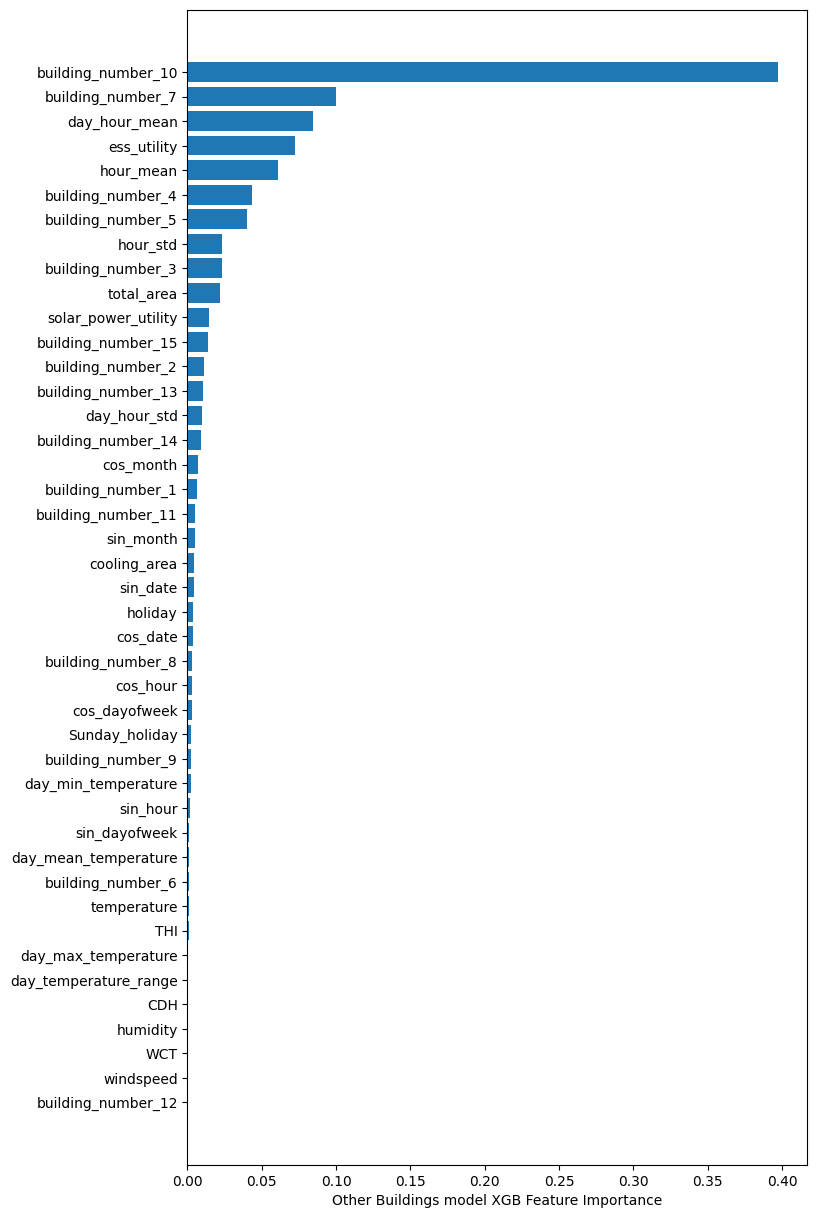

Building type = Other Buildings : XGBRegressor Model SMAPE : 3.7055


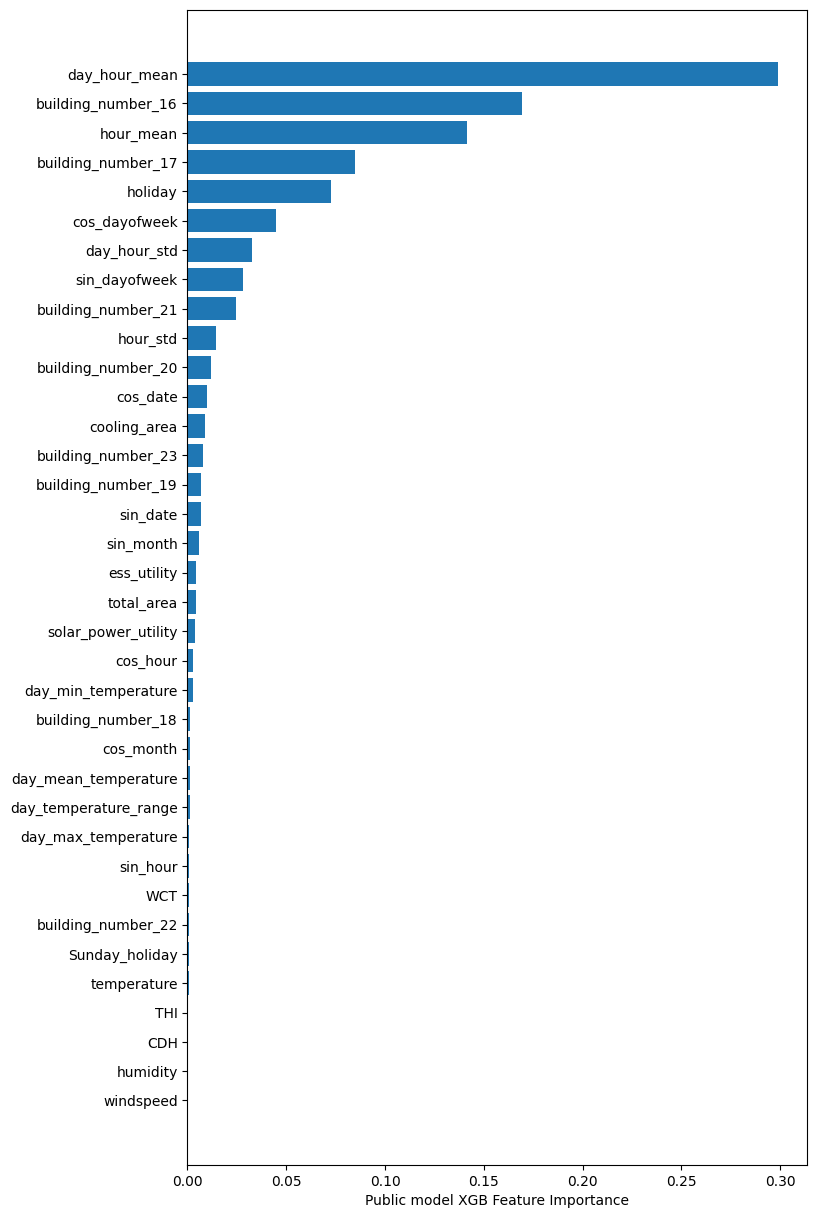

Building type = Public : XGBRegressor Model SMAPE : 2.6083


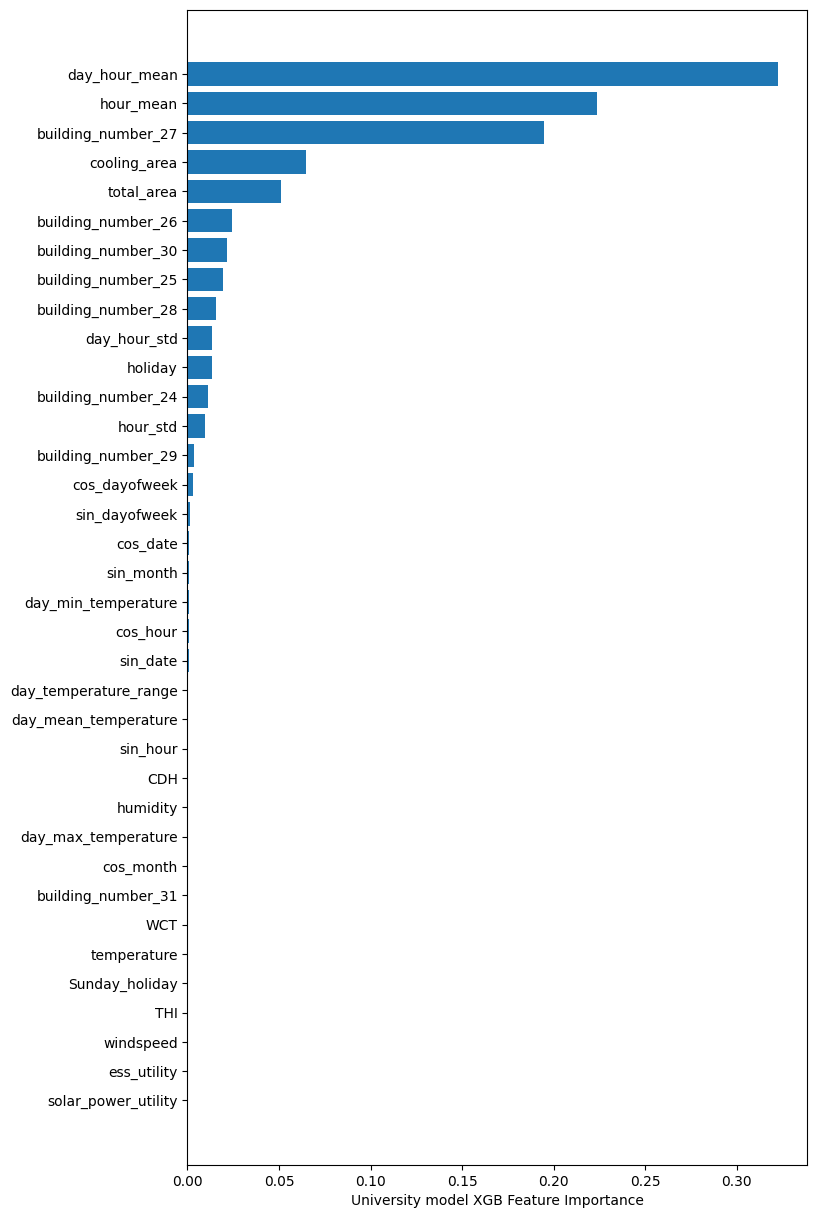

Building type = University : XGBRegressor Model SMAPE : 1.9736


In [ ]:
kf = KFold(n_splits = 7,shuffle=True,random_state=RANDOM_SEED)
answer_df = pd.DataFrame(columns=['answer'])
pred_df = pd.DataFrame(columns=['pred'])



for i in type_list:

    x = X[(X.building_type == i)]
    y = Y[(Y.building_type == i)]
    X_test = test_X[test_X.building_type==i]

    x = pd.get_dummies(x, columns=['building_number'], drop_first=False)
    X_test = pd.get_dummies(X_test, columns=['building_number'], drop_first=False)

    x = x.drop(['building_type'],axis =1)
    X_test = X_test.drop(['building_type'],axis =1)
    y = y['power_consumption']
    x_columns = np.array(x.columns)
    x = np.array(x) ; y = np.array(y)

    j = 0
    xgb_fold_smape = []
    answer_list = []
    pred = pd.DataFrame(index = range(0,y.shape[0]), columns=['pred'])
    answer = pd.DataFrame(columns=['answer'])

    for train_index, valid_index in kf.split(x):
        j += 1



        X_train, X_valid = x[train_index], x[valid_index]
        Y_train, Y_valid = y[train_index], y[valid_index]
        Y_train = np.log(Y_train) ; Y_valid = np.log(Y_valid)


        evals = [(X_train,Y_train),(X_valid,Y_valid)]
        xgb_model = XGBRegressor(learning_rate = 0.05,n_estimators = 5000,
                             max_depth = int(xgb_best_params.loc[i]['max_depth']),
                             random_state = RANDOM_SEED,
                            subsample = xgb_best_params.loc[i]['subsample'],
                             colsample_bytree = xgb_best_params.loc[i]['colsample_bytree'],
                             min_child_weight = int(xgb_best_params.loc[i]['min_child_weight']),
                             objective=weighted_mse(xgb_best_params.loc[i]['alpha']))

        xgb_model.fit(X_train, Y_train, early_stopping_rounds = 100,
                       eval_metric = custom_smape, eval_set = evals, verbose = False)
        xgb_pred = xgb_model.predict(X_valid)
        xgb_pred = np.exp(xgb_pred)
        pred['pred'][valid_index] = xgb_pred
        xgb_smape = smape(np.exp(Y_valid),xgb_pred)
        xgb_answer = xgb_model.predict(X_test)
        answer_list.append(np.exp(xgb_answer))
        xgb_fold_smape.append(xgb_smape)


        if j == 7:
            sorted_idx = xgb_model.feature_importances_.argsort()
            plt.figure(figsize=(8,15))
            plt.barh(x_columns[sorted_idx],  xgb_model.feature_importances_[sorted_idx])
            plt.xlabel('%s model XGB Feature Importance'%(i))
            plt.show()


    type_answer = sum(answer_list) / len(answer_list)

    answer.answer = type_answer
    answer_df = pd.concat([answer_df,answer],ignore_index=True)
    pred_df = pd.concat([pred_df,pred],ignore_index=True)

    avg_smape = sum(xgb_fold_smape) / len(xgb_fold_smape)
    print('Building type = %s : XGBRegressor Model SMAPE : %.4f' %(i,avg_smape))


total_score = smape(Y.power_consumption,pred_df.pred)
print('Total SMAPE : %.4f'%(total_score))

* xgb 파라미터 미리 csv 형태로 만들기

In [29]:
import csv

# 데이터
data = [
    ["building_type", "max_depth", "alpha", "subsample", "colsample_bytree", "min_child_weight"],
    ["Other Buildings", 10, 3, 0.7, 0.5, 3],
    ["Public", 10, 3, 0.7, 0.5, 3],
    ["University", 8, 3, 0.7, 0.5, 3],
    ["Data Center", 6, 3, 0.7, 0.5, 3],
    ["Department Store and Outlet", 8, 3, 0.7, 0.5, 3],
    ["Hospital", 8, 3, 0.7, 0.5, 3],
    ["Commercial", 10, 3, 0.7, 0.5, 3],
    ["Apartment", 6, 3, 0.7, 0.5, 3],
    ["Research Institute", 10, 3, 0.7, 0.5, 3],
    ["Knowledge Industry Center", 8, 3, 0.7, 0.5, 3],
    ["Discount Mart", 8, 3, 0.7, 0.5, 3],
    ["Hotel and Resort", 10, 3, 0.7, 0.5, 3]
]

# CSV 파일로 저장
filename = '5_07 xgb 파라미터.csv'
with open(filename, 'w', newline='', encoding='utf-8') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerows(data)